In [70]:
def cleaning_tweets(text):
    ''' Clean tweets with regex patterns
    
    Args : 
        - text : string
    
    Returns : 
        A transformed text
    '''

    text = str(text)
    text = text.lower()

    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.split()

    return text

In [71]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv('../tweets/tweets_remaining_09042020_16072020.csv', delimiter=';')

df['Date'] = df['created_at'].str.split().str[0]

df = df[df['text'].str.contains("msft")]

sia = SentimentIntensityAnalyzer()

df['Sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

sentiment_df = df[['Date', 'Sentiment']]

average_sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

print(average_sentiment_df)


          Date  Sentiment
0   2020-04-09   0.092716
1   2020-04-10   0.079249
2   2020-04-11   0.077346
3   2020-04-12   0.123964
4   2020-04-13   0.055267
..         ...        ...
72  2020-07-12   0.106335
73  2020-07-13   0.087838
74  2020-07-14   0.037963
75  2020-07-15   0.054084
76  2020-07-16   0.031192

[77 rows x 2 columns]


In [72]:
import yfinance as yf
msft_df = yf.download("MSFT", start="2020-04-09", end="2020-07-16", progress=False)

In [73]:
average_sentiment_df['Date'] = pd.to_datetime(average_sentiment_df['Date'])

average_sentiment_df = average_sentiment_df[average_sentiment_df['Date'].isin(msft_df.index)]
msft_df = msft_df[msft_df.index.isin(average_sentiment_df['Date'])]
average_sentiment_df = average_sentiment_df.reset_index(drop=True)
msft_df = msft_df.reset_index(drop=True)

In [74]:
msft_df['Sentiment'] = average_sentiment_df['Sentiment'].to_numpy()

In [75]:
msft_df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment
0,166.360001,167.369995,163.330002,165.139999,159.275269,51385100,0.092716
1,164.350006,165.570007,162.300003,165.509995,159.632141,41905300,0.055267
2,169.000000,173.750000,168.000000,173.699997,167.531281,52874300,0.062544
3,171.199997,173.570007,169.240005,171.880005,165.775940,40940800,0.114921
4,174.300003,177.279999,172.899994,177.039993,170.752701,50479600,0.075718


In [76]:
msft_df["Tomorrow"] = msft_df["Close"].shift(-1)

In [77]:
msft_df["Target"] = (msft_df["Tomorrow"] > msft_df["Close"]).astype(int)


## K-Nearest Neighbors

In [78]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(msft_df[['Open', 'High', 'Low', 'Close',
'Adj Close', 'Volume', 'Sentiment']], msft_df['Target'], test_size=0.2, random_state=42, shuffle=False)

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

test_df = msft_df[msft_df.index.isin(X_test.index)]
test_df['Predictions'] = y_pred

/var/folders/9f/tqhf2_lj7x9g9w7kvpf8_91r0000gn/T/ipykernel_81087/2402974250.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = y_pred


In [79]:
print(test_df)
test_df = test_df.reset_index(drop=True)


          Open        High         Low       Close   Adj Close    Volume   
41  197.880005  204.399994  197.740005  203.509995  196.829300  34310300  \
42  203.139999  206.350006  201.770004  204.699997  197.980270  32061200   
43  205.679993  208.020004  205.000000  206.259995  199.489014  29315800   
44  208.830002  211.130005  208.089996  210.699997  203.783249  31897600   
45  210.449997  214.669998  207.990005  208.250000  201.413712  33600700   
46  210.070007  213.259995  208.690002  212.830002  205.843338  33600000   
47  216.330002  216.380005  211.470001  214.320007  207.284439  33121700   
48  213.619995  214.080002  211.080002  213.669998  206.655762  26177600   
49  214.479996  215.800003  206.500000  207.070007  200.272430  38135600   
50  206.130005  208.850006  202.029999  208.350006  201.510422  37591800   
51  209.559998  211.330002  205.029999  208.039993  201.210556  32179400   

    Sentiment    Tomorrow  Target  Predictions  
41   0.122084  204.699997       1     

In [80]:
# changing Predictions to 1 if it is greater than 0.6 and 0 otherwise
test_df['Predictions'] = np.where(test_df['Predictions'] > 0.5, 1, 0)
test_df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment,Tomorrow,Target,Predictions
0,197.880005,204.399994,197.740005,203.509995,196.829300,34310300,0.122084,204.699997,1,1
1,203.139999,206.350006,201.770004,204.699997,197.980270,32061200,0.072288,206.259995,1,1
2,205.679993,208.020004,205.000000,206.259995,199.489014,29315800,0.058403,210.699997,1,1
3,208.830002,211.130005,208.089996,210.699997,203.783249,31897600,0.143329,208.250000,0,1
4,210.449997,214.669998,207.990005,208.250000,201.413712,33600700,0.086555,212.830002,1,1


In [81]:
wallet = 10000
wallet_value = []  
for i in range(len(test_df)):
    if (test_df['Predictions'][i] == 1) and (test_df['Target'][i] == 1):
        wallet += (test_df['Tomorrow'][i] - test_df['Adj Close'][i])
    elif (test_df['Predictions'][i] == 0) and (test_df['Target'][i] == 0):
        wallet += (test_df['Adj Close'][i] - test_df['Tomorrow'][i])
    else:
        wallet -= abs((test_df['Tomorrow'][i] - test_df['Adj Close'][i]))
    wallet_value.append(wallet)

test_df['Wallet'] = wallet_value


          Open        High         Low       Close   Adj Close    Volume   
0     0.000000    0.000000    0.000000    0.000000    0.000000         0  \
1   197.880005  204.399994  197.740005  203.509995  196.829300  34310300   
2   203.139999  206.350006  201.770004  204.699997  197.980270  32061200   
3   205.679993  208.020004  205.000000  206.259995  199.489014  29315800   
4   208.830002  211.130005  208.089996  210.699997  203.783249  31897600   
5   210.449997  214.669998  207.990005  208.250000  201.413712  33600700   
6   210.070007  213.259995  208.690002  212.830002  205.843338  33600000   
7   216.330002  216.380005  211.470001  214.320007  207.284439  33121700   
8   213.619995  214.080002  211.080002  213.669998  206.655762  26177600   
9   214.479996  215.800003  206.500000  207.070007  200.272430  38135600   
10  206.130005  208.850006  202.029999  208.350006  201.510422  37591800   
11  209.559998  211.330002  205.029999  208.039993  201.210556  32179400   

    Sentime

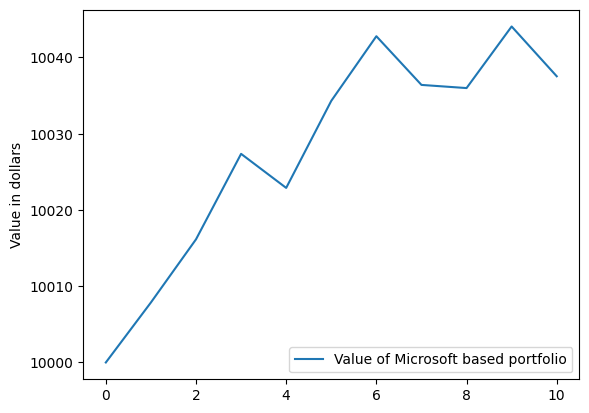

In [82]:
wallet_df = test_df.copy()
wallet_df = wallet_df.drop(wallet_df.index[0:60])

wallet_df.loc[-1] = [0] * len(wallet_df.columns)
wallet_df.index = wallet_df.index + 1
wallet_df = wallet_df.sort_index()
wallet_df.loc[0, 'Wallet'] = 10000


wallet_df = wallet_df.reset_index(drop=True)
wallet_df = pd.concat([wallet_df, test_df], ignore_index=True)


print(wallet_df)

plt.plot(wallet_df['Wallet'], label='Value of Microsoft based portfolio')
plt.ylabel('Value in dollars')
plt.legend()
plt.show()



In [83]:
print((wallet_df['Wallet'][len(wallet_df)-2] - wallet_df['Wallet'][0])/wallet_df['Wallet'][0]*100)


0.3753581237792969
